In [1]:
%matplotlib widget

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ---------------- Utilities ----------------

def sph_to_cart(lon_deg: float, lat_deg: float) -> np.ndarray:
    lon = np.deg2rad(lon_deg)
    lat = np.deg2rad(lat_deg)
    return np.array([
        np.cos(lat) * np.cos(lon),
        np.cos(lat) * np.sin(lon),
        np.sin(lat)
    ], dtype=float)

def normalize(v: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(v)
    return v if n == 0 else v / n

def slerp(u: np.ndarray, v: np.ndarray, n: int = 200) -> np.ndarray:
    u = normalize(u)
    v = normalize(v)
    dot = np.clip(np.dot(u, v), -1.0, 1.0)
    omega = np.arccos(dot)
    if omega < 1e-14:
        return np.repeat(u[None, :], n, axis=0)
    t = np.linspace(0.0, 1.0, n)
    so = np.sin(omega)
    return (np.sin((1 - t) * omega)[:, None] / so) * u + (np.sin(t * omega)[:, None] / so) * v

def great_circle(p: np.ndarray, n: np.ndarray, npts: int = 361) -> np.ndarray:
    n = normalize(n)
    u = normalize(p - np.dot(p, n) * n)
    if np.linalg.norm(u) < 1e-14:
        tmp = np.array([1.0, 0.0, 0.0])
        if abs(np.dot(tmp, n)) > 0.9:
            tmp = np.array([0.0, 1.0, 0.0])
        u = normalize(np.cross(n, tmp))
    v = normalize(np.cross(n, u))
    t = np.linspace(0.0, 2.0 * np.pi, npts)
    return np.outer(np.cos(t), u) + np.outer(np.sin(t), v)

def sign_pm1(x: float, eps: float = 0.0) -> int:
    if x > eps:
        return +1
    if x < -eps:
        return -1
    return 0

def orient3d_sign(P: np.ndarray, Q: np.ndarray, X: np.ndarray, eps: float = 0.0) -> int:
    # sign(Orient3D(P,Q,O,X)) = sign((P×Q)·X)
    return sign_pm1(float(np.dot(np.cross(P, Q), X)), eps=eps)

def label_point(ax, name: str, P: np.ndarray, scale: float = 1.12):
    Q = P * scale
    ax.text(Q[0], Q[1], Q[2], name, fontsize=14, ha="center", va="center")

def add_direction_arrow(ax, arc_pts: np.ndarray, frac: float = 0.55, length: float = 0.18):
    n = arc_pts.shape[0]
    i = int(np.clip(frac * (n - 2), 0, n - 2))
    p = arc_pts[i]
    d = normalize(arc_pts[i + 1] - arc_pts[i]) * length
    ax.quiver(p[0], p[1], p[2], d[0], d[1], d[2],
              arrow_length_ratio=0.4, linewidth=2)

def fmt_vec(v: np.ndarray, ndigits: int = 3) -> str:
    v = np.asarray(v, dtype=float)
    return "(" + ", ".join(f"{x:+.{ndigits}f}" for x in v) + ")"

def orient_report(A, B, C, D):
    sC = orient3d_sign(A, B, C)   # Orient3D(A,B,O,C)
    sD = orient3d_sign(A, B, D)   # Orient3D(A,B,O,D)
    tA = orient3d_sign(C, D, A)   # Orient3D(C,D,O,A)
    tB = orient3d_sign(C, D, B)   # Orient3D(C,D,O,B)

    ok = (tA == sD) and (sC == tB) and (sD == -sC)
    return sC, sD, tA, tB, ok


In [3]:
def plot_case(ax, A, B, C, D, case_title: str):

    # Front reference: lon=0, lat=0 (points along +x)
    F = sph_to_cart(0, 0)

    # Unit normals of planes (A,B,O) and (C,D,O)
    nAB = normalize(np.cross(A, B))
    nCD = normalize(np.cross(C, D))

    # Geometry (great circles + minor arcs)
    gcAB = great_circle(A, nAB)
    gcCD = great_circle(C, nCD)
    arcAB = slerp(A, B, n=240)
    arcCD = slerp(C, D, n=240)

    # Orient3D signs
    sC = orient3d_sign(A, B, C)   # Orient3D(A,B,O,C)
    sD = orient3d_sign(A, B, D)   # Orient3D(A,B,O,D)
    tA = orient3d_sign(C, D, A)   # Orient3D(C,D,O,A)
    tB = orient3d_sign(C, D, B)   # Orient3D(C,D,O,B)

    # ---- Notebook printout (move verbose stuff here) ----
    print(case_title)
    print(f"  n_ABO = normalize(A×B) = {fmt_vec(nAB)}")
    print(f"  n_CDO = normalize(C×D) = {fmt_vec(nCD)}")
    print(f"  Orient3D(A,B,O,C) = {sC:+d}  ; Orient3D(A,B,O,D) = {sD:+d}")
    print(f"  Orient3D(C,D,O,A) = {tA:+d}  ; Orient3D(C,D,O,B) = {tB:+d}")
    print("  s_X: hemisphere sign of X w.r.t. plane (A,B,O)")
    print("  t_X: hemisphere sign of X w.r.t. plane (C,D,O)")
    print()

    # ---- Sphere wireframe (slightly denser + lighter) ----
    uu = np.linspace(0, 2 * np.pi, 80)
    vv = np.linspace(0, np.pi, 40)
    xs = np.outer(np.cos(uu), np.sin(vv))
    ys = np.outer(np.sin(uu), np.sin(vv))
    zs = np.outer(np.ones_like(uu), np.cos(vv))
    ax.plot_wireframe(xs, ys, zs, rstride=3, cstride=3, linewidth=0.5, alpha=0.18)

    # Great circles
    h_gcAB, = ax.plot(gcAB[:, 0], gcAB[:, 1], gcAB[:, 2], linewidth=2.0)
    h_gcCD, = ax.plot(gcCD[:, 0], gcCD[:, 1], gcCD[:, 2], linewidth=2.0)

    # Minor arcs
    h_arcAB, = ax.plot(arcAB[:, 0], arcAB[:, 1], arcAB[:, 2], linewidth=5.0)
    h_arcCD, = ax.plot(arcCD[:, 0], arcCD[:, 1], arcCD[:, 2], linewidth=5.0)

    # Points
    ax.scatter(*A, s=110)
    ax.scatter(*B, s=110)
    ax.scatter(*C, s=110)
    ax.scatter(*D, s=110)

    # Front reference marker + label
    ax.scatter(*F, s=140, marker="x", linewidths=3)
    ax.text(*(F * 1.28), "front (0°,0°)", fontsize=12, ha="center", va="center")

    # Labels moved away
    label_point(ax, "a", A)
    label_point(ax, "b", B)
    label_point(ax, "c", C)
    label_point(ax, "d", D)

    # Sign labels moved away
    ax.text(*(C * 1.22), f"s_C={sC:+d}", fontsize=12)
    ax.text(*(D * 1.22), f"s_D={sD:+d}", fontsize=12)
    ax.text(*(A * 1.22), f"t_A={tA:+d}", fontsize=12)
    ax.text(*(B * 1.22), f"t_B={tB:+d}", fontsize=12)

    # Direction arrows (a->b and c->d)
    add_direction_arrow(ax, arcAB, frac=0.60, length=0.18)
    add_direction_arrow(ax, arcCD, frac=0.60, length=0.18)

    # ---- Minimal legend (only geometry layers) ----
    legend_items = [
        Line2D([0], [0], lw=3, color=h_arcAB.get_color(), label="minor arc a→b"),
        Line2D([0], [0], lw=3, color=h_arcCD.get_color(), label="minor arc c→d"),
        Line2D([0], [0], lw=2, color=h_gcAB.get_color(), label="GCA through AB"),
        Line2D([0], [0], lw=2, color=h_gcCD.get_color(), label="GCA through CD"),
    ]
    ax.legend(handles=legend_items, loc="center left",
              bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0, framealpha=0.95)

    # Make sphere visually larger within the cube
    ax.set_xlim([-1.02, 1.02])
    ax.set_ylim([-1.02, 1.02])
    ax.set_zlim([-1.02, 1.02])

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title(case_title)

    # Nice default camera (still rotatable)
    ax.view_init(elev=18, azim=-60)
    try:
        ax.dist = 8  # smaller = closer (may be deprecated; safe to ignore warnings)
    except Exception:
        pass



## Intersection case 

### (front)


Case 1: intersection (front)
  n_ABO = normalize(A×B) = (-0.000, +0.000, +1.000)
  n_CDO = normalize(C×D) = (-0.000, +1.000, +0.000)
  Orient3D(A,B,O,C) = +1  ; Orient3D(A,B,O,D) = -1
  Orient3D(C,D,O,A) = -1  ; Orient3D(C,D,O,B) = +1
  s_X: hemisphere sign of X w.r.t. plane (A,B,O)
  t_X: hemisphere sign of X w.r.t. plane (C,D,O)



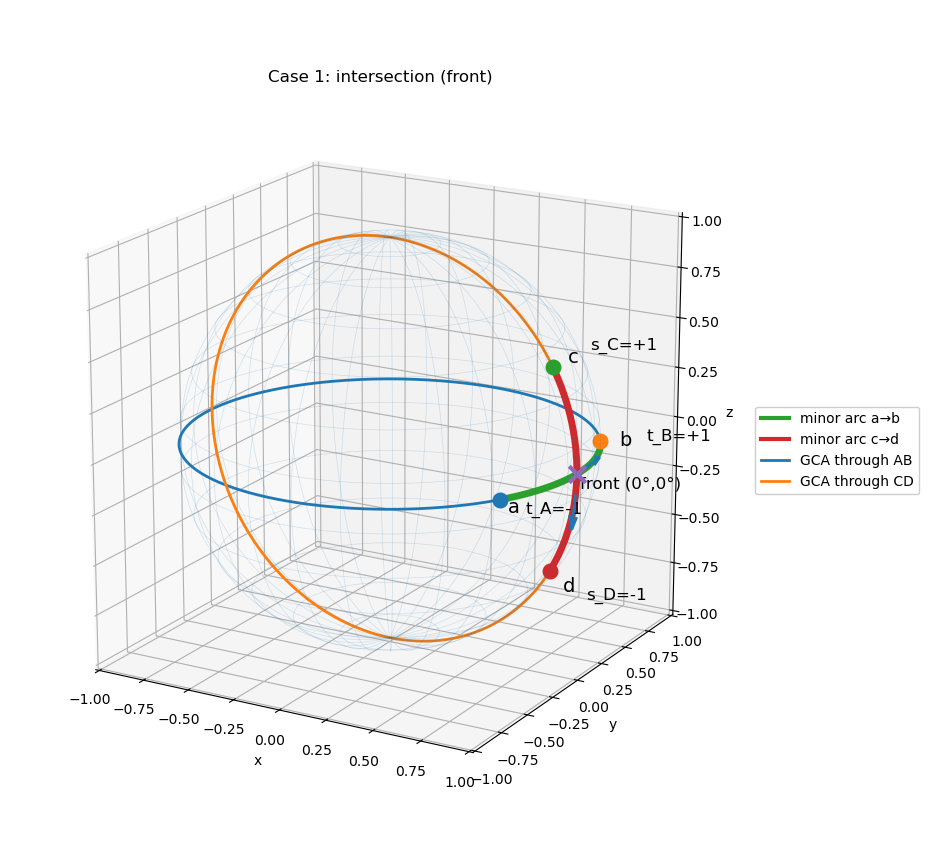

In [4]:

A = sph_to_cart(-30, 0)     # a
B = sph_to_cart(30, 0)      # b
C = sph_to_cart(0, 30)      # c
D = sph_to_cart(0, -30)     # d

fig = plt.figure(figsize=(9.5, 8.5))
ax = fig.add_subplot(111, projection="3d")
ax.set_box_aspect((1, 1, 1))

plot_case(ax, A, B, C, D, "Case 1: intersection (front)")

# more room for axes, still enough space for the legend
fig.subplots_adjust(left=0.02, right=0.78, bottom=0.02, top=0.92)
plt.show()


### (back)

Case 2: intersection (back)
  n_ABO = normalize(A×B) = (+0.000, +0.000, +1.000)
  n_CDO = normalize(C×D) = (+0.000, +1.000, +0.000)
  Orient3D(A,B,O,C) = -1  ; Orient3D(A,B,O,D) = +1
  Orient3D(C,D,O,A) = +1  ; Orient3D(C,D,O,B) = -1
  s_X: hemisphere sign of X w.r.t. plane (A,B,O)
  t_X: hemisphere sign of X w.r.t. plane (C,D,O)



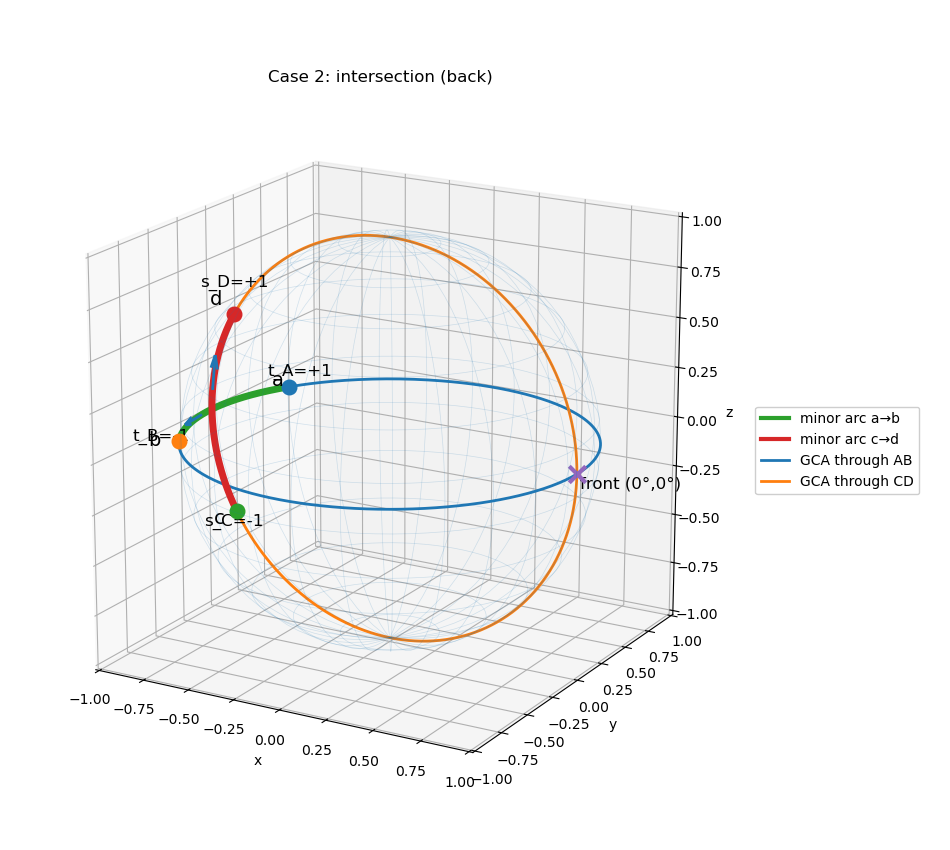

In [5]:

A = sph_to_cart(-30 + 180, 0)   # a
B = sph_to_cart(30 + 180, 0)    # b
C = sph_to_cart(0 + 180, -30)   # c
D = sph_to_cart(0 + 180, 30)    # d

fig = plt.figure(figsize=(9.5, 8.5))
ax = fig.add_subplot(111, projection="3d")
ax.set_box_aspect((1, 1, 1))

plot_case(ax, A, B, C, D, "Case 2: intersection (back)")

# more room for axes, still enough space for the legend
fig.subplots_adjust(left=0.02, right=0.78, bottom=0.02, top=0.92)
plt.show()



## Orient3D Sign Consistency for Spherical Arc–Arc Intersection

In the generic case, an intersection between two minor spherical arcs \(AB\) and
\(CD\) can be characterized purely by the consistency of a small set of
\texttt{Orient3D} predicates, without explicitly computing the intersection
point.

Using the sign convention
$\texttt{Orient3D}(P,Q,O,X) = \operatorname{sign}((P \times Q)\cdot X)$,
S2’s intersection logic reduces to the following necessary and sufficient
condition:

$$
\texttt{Orient3D}(C,D,O,A)
=
\texttt{Orient3D}(A,B,O,D)
=
-\texttt{Orient3D}(A,B,O,C)
=
-\texttt{Orient3D}(C,D,O,B).
$$



In [6]:
def print_orient_table(cases, C, D):
    headers = [
        "Case",
        "O3D(A,B,O,C)",
        "O3D(A,B,O,D)",
        "O3D(C,D,O,A)",
        "O3D(C,D,O,B)",
        "Consistency?"
    ]

    rows = []
    for title, A, B in cases:
        sC = orient3d_sign(A, B, C)
        sD = orient3d_sign(A, B, D)
        tA = orient3d_sign(C, D, A)
        tB = orient3d_sign(C, D, B)

        ok = (tA == sD) and (sD == -sC) and (-sC == -tB)

        rows.append([
            title,
            f"{sC:+d}",
            f"{sD:+d}",
            f"{tA:+d}",
            f"{tB:+d}",
            "✔︎" if ok else "✘"
        ])

    # column widths
    col_widths = [max(len(str(row[i])) for row in ([headers] + rows))
                  for i in range(len(headers))]

    def fmt_row(row):
        return " | ".join(str(cell).ljust(col_widths[i])
                          for i, cell in enumerate(row))

    print(fmt_row(headers))
    print("-+-".join("-" * w for w in col_widths))
    for row in rows:
        print(fmt_row(row))


90° left of CD
  n_ABO = normalize(A×B) = (+0.000, +0.000, +1.000)
  n_CDO = normalize(C×D) = (-0.000, +1.000, +0.000)
  Orient3D(A,B,O,C) = +1  ; Orient3D(A,B,O,D) = -1
  Orient3D(C,D,O,A) = -1  ; Orient3D(C,D,O,B) = -1
  s_X: hemisphere sign of X w.r.t. plane (A,B,O)
  t_X: hemisphere sign of X w.r.t. plane (C,D,O)

crossing CD
  n_ABO = normalize(A×B) = (-0.000, +0.000, +1.000)
  n_CDO = normalize(C×D) = (-0.000, +1.000, +0.000)
  Orient3D(A,B,O,C) = +1  ; Orient3D(A,B,O,D) = -1
  Orient3D(C,D,O,A) = -1  ; Orient3D(C,D,O,B) = +1
  s_X: hemisphere sign of X w.r.t. plane (A,B,O)
  t_X: hemisphere sign of X w.r.t. plane (C,D,O)

90° right of CD
  n_ABO = normalize(A×B) = (+0.000, -0.000, +1.000)
  n_CDO = normalize(C×D) = (-0.000, +1.000, +0.000)
  Orient3D(A,B,O,C) = +1  ; Orient3D(A,B,O,D) = -1
  Orient3D(C,D,O,A) = +1  ; Orient3D(C,D,O,B) = +1
  s_X: hemisphere sign of X w.r.t. plane (A,B,O)
  t_X: hemisphere sign of X w.r.t. plane (C,D,O)

antipodal to CD
  n_ABO = normalize(A×B) =

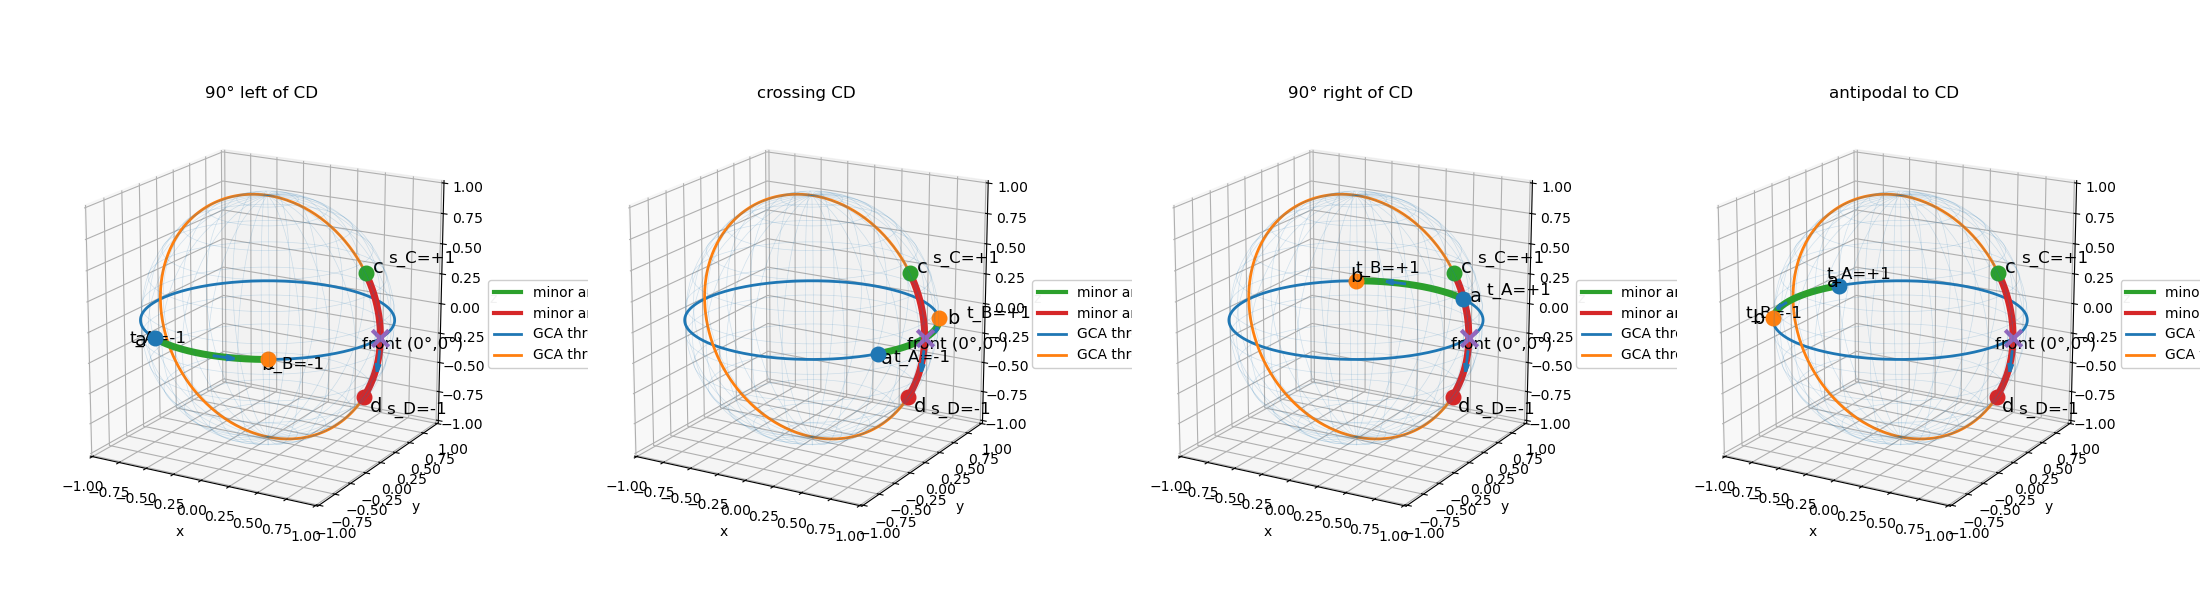

Case            | O3D(A,B,O,C) | O3D(A,B,O,D) | O3D(C,D,O,A) | O3D(C,D,O,B) | Consistency?
----------------+--------------+--------------+--------------+--------------+-------------
90° left of CD  | +1           | -1           | -1           | -1           | ✘           
crossing CD     | +1           | -1           | -1           | +1           | ✔︎          
90° right of CD | +1           | -1           | +1           | +1           | ✘           
antipodal to CD | +1           | -1           | +1           | -1           | ✘           


In [7]:

# Fixed front edge CD
C = sph_to_cart(0, 30)
D = sph_to_cart(0, -30)

cases = [
    ("90° left of CD",
     sph_to_cart(-30 - 90, 0),
     sph_to_cart( 30 - 90, 0)),

    ("crossing CD",
     sph_to_cart(-30, 0),
     sph_to_cart( 30, 0)),

    ("90° right of CD",
     sph_to_cart(-30 + 90, 0),
     sph_to_cart( 30 + 90, 0)),

    ("antipodal to CD",
     sph_to_cart(-30 + 180, 0),
     sph_to_cart( 30 + 180, 0)),
]



fig = plt.figure(figsize=(22, 6))
axes = [fig.add_subplot(1, 4, i + 1, projection="3d") for i in range(4)]
for ax in axes:
    ax.set_box_aspect((1, 1, 1))

for ax, (title, A, B) in zip(axes, cases):
    plot_case(ax, A, B, C, D, title)

# spacing without tight_layout (3D-safe)
fig.subplots_adjust(left=0.02, right=0.96, bottom=0.02, top=0.90, wspace=0.25)
plt.show()

print_orient_table(cases, C, D)

